In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow


In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio


In [4]:
tf.config.list_physical_devices('GPU')


[]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass


# **1.Build Data Loading Functions**

In [6]:
import gdown


In [7]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')


Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=72f747e6-c8f7-4e1e-bac8-d066c8e1770c
To: /content/data.zip
100%|██████████| 423M/423M [00:03<00:00, 116MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [8]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std


In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]


In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num.get_vocabulary()
char_to_num(['n','i','c','k'])


<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [12]:
num_to_char([14,  9,  3, 11])


<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [13]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


In [14]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [15]:
test_path = '.data/alignments/s1/swio3a.align'


In [16]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]


'swio3a'

In [17]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[ 1.4737673 ],
          [ 1.4737673 ],
          [ 1.515875  ],
          ...,
          [ 0.08421528],
          [ 0.08421528],
          [ 0.08421528]],
 
         [[ 1.4737673 ],
          [ 1.4737673 ],
          [ 1.515875  ],
          ...,
          [ 0.08421528],
          [ 0.08421528],
          [ 0.08421528]],
 
         [[ 1.515875  ],
          [ 1.515875  ],
          [ 1.4737673 ],
          ...,
          [ 0.04210764],
          [ 0.        ],
          [ 0.        ]],
 
         ...,
 
         [[ 1.052691  ],
          [ 1.052691  ],
          [ 1.052691  ],
          ...,
          [10.526909  ],
          [10.526909  ],
          [10.526909  ]],
 
         [[ 1.052691  ],
          [ 1.052691  ],
          [ 1.052691  ],
          ...,
          [10.526909  ],
          [10.526909  ],
          [10.526909  ]],
 
         [[ 1.052691  ],
          [ 1.052691  ],
          [ 1.052691  ],
          

In [18]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))


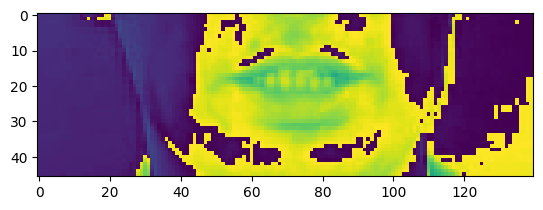

In [19]:
plt.imshow(frames[40])


In [20]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])


<tf.Tensor: shape=(), dtype=string, numpy=b'set white in o three again'>

In [21]:
def mappable_function(path:str)->List[str]:
  result=tf.py_function(load_data,[path],(tf.float32,tf.int64))
  return result

# **2.Create Pipeline**

In [22]:
from matplotlib import pyplot as plt


In [23]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)



In [24]:
len(test)


50

In [25]:
import tensorflow_datasets as tfds

In [26]:
frames, alignments = data.as_numpy_iterator().next()

In [27]:
len(frames)

2

In [28]:
sample=data.as_numpy_iterator()

In [29]:
val=sample.next();val[0]

array([[[[[1.4030875 ],
          [1.3311343 ],
          [1.4390641 ],
          ...,
          [0.32378942],
          [0.2518362 ],
          [0.2518362 ]],

         [[1.3311343 ],
          [1.2232045 ],
          [1.4390641 ],
          ...,
          [0.32378942],
          [0.2518362 ],
          [0.2518362 ]],

         [[1.4390641 ],
          [1.4390641 ],
          [1.4390641 ],
          ...,
          [0.35976604],
          [0.32378942],
          [0.32378942]],

         ...,

         [[1.1152747 ],
          [1.079298  ],
          [1.079298  ],
          ...,
          [0.        ],
          [0.        ],
          [9.138057  ]],

         [[1.079298  ],
          [1.079298  ],
          [1.079298  ],
          ...,
          [0.        ],
          [0.0359766 ],
          [0.0359766 ]],

         [[1.079298  ],
          [1.079298  ],
          [1.079298  ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]]],


        [[[1.2951

In [30]:
fv = (val[0][1].astype(np.uint8) * 255).squeeze()
imageio.mimsave('./animation.gif', fv, duration=100)

In [31]:
imageio.mimsave('./animation.gif', fv, fps=10)


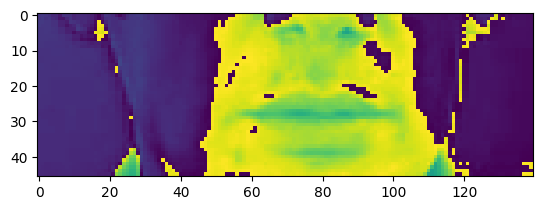

In [32]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][74])

In [33]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue with r four please'>

# **Design The Deep Neural Network**

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [35]:
data.as_numpy_iterator().next()[0][0].shape


(75, 46, 140, 1)

In [36]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [38]:
yhat=model.predict(val[0])

1/1 [==============================] - 18s 18s/step


In [39]:
yhat[0]

array([[0.02303886, 0.02143233, 0.02235787, ..., 0.02388759, 0.01940613,
        0.02223636],
       [0.02275195, 0.02091   , 0.02310554, ..., 0.0234744 , 0.01917187,
        0.02275341],
       [0.02239682, 0.02047894, 0.02383104, ..., 0.02312459, 0.01907981,
        0.0230565 ],
       ...,
       [0.022458  , 0.02157668, 0.02685791, ..., 0.02689127, 0.02256128,
        0.02489069],
       [0.0220843 , 0.02209362, 0.02646954, ..., 0.02670751, 0.02345948,
        0.02501274],
       [0.02159651, 0.02266332, 0.02560023, ..., 0.02668164, 0.02429217,
        0.02490145]], dtype=float32)

In [40]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[1],axis=1)])


<tf.Tensor: shape=(), dtype=string, numpy=b'p2222222222222222222222222222222222222222222222222222222222222222!!!!!!!!!f'>

# **4.Setup Training Options and Train**

In [41]:


def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


In [42]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [43]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [44]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)


In [45]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)


In [46]:
schedule_callback = LearningRateScheduler(scheduler)


In [47]:
example_callback = ProduceExample(test)


In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])


Epoch 1/100
 62/450 [===>..........................] - ETA: 6:09:09 - loss: 117.9794